# Application
The goal of this Notebook is to find the best features from Application and Sub Data clusters.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb


%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

# Application dataset
application_train dataset has:
* 307511 observations and 122 features
* No duplicates
* Groups of features have Null values

In [2]:
application_train = help_tool.csv_download(
    r'Archive\home-credit-default-risk\application_train.csv')
help_tool.first_look(application_train)

Dataset has 307511 observations and 122 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
TARGET,int64,0,0.0
NAME_CONTRACT_TYPE,object,0,0.0
CODE_GENDER,object,0,0.0
FLAG_OWN_CAR,object,0,0.0
...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_WEEK,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,float64,41519,13.5
AMT_REQ_CREDIT_BUREAU_QRT,float64,41519,13.5


In [3]:
application_train.drop(
    columns=['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START'], inplace=True)

### Cleaning object features
Before feature selection for Target, object type columns must be handled. OneHotEncoding is a not good approach (the dataset has 16 object type features), which would result of column number explosion and would confuse the Light GBM model when fitting for feature importance.

In [4]:
application_train = help_tool.convert_flags(application_train)

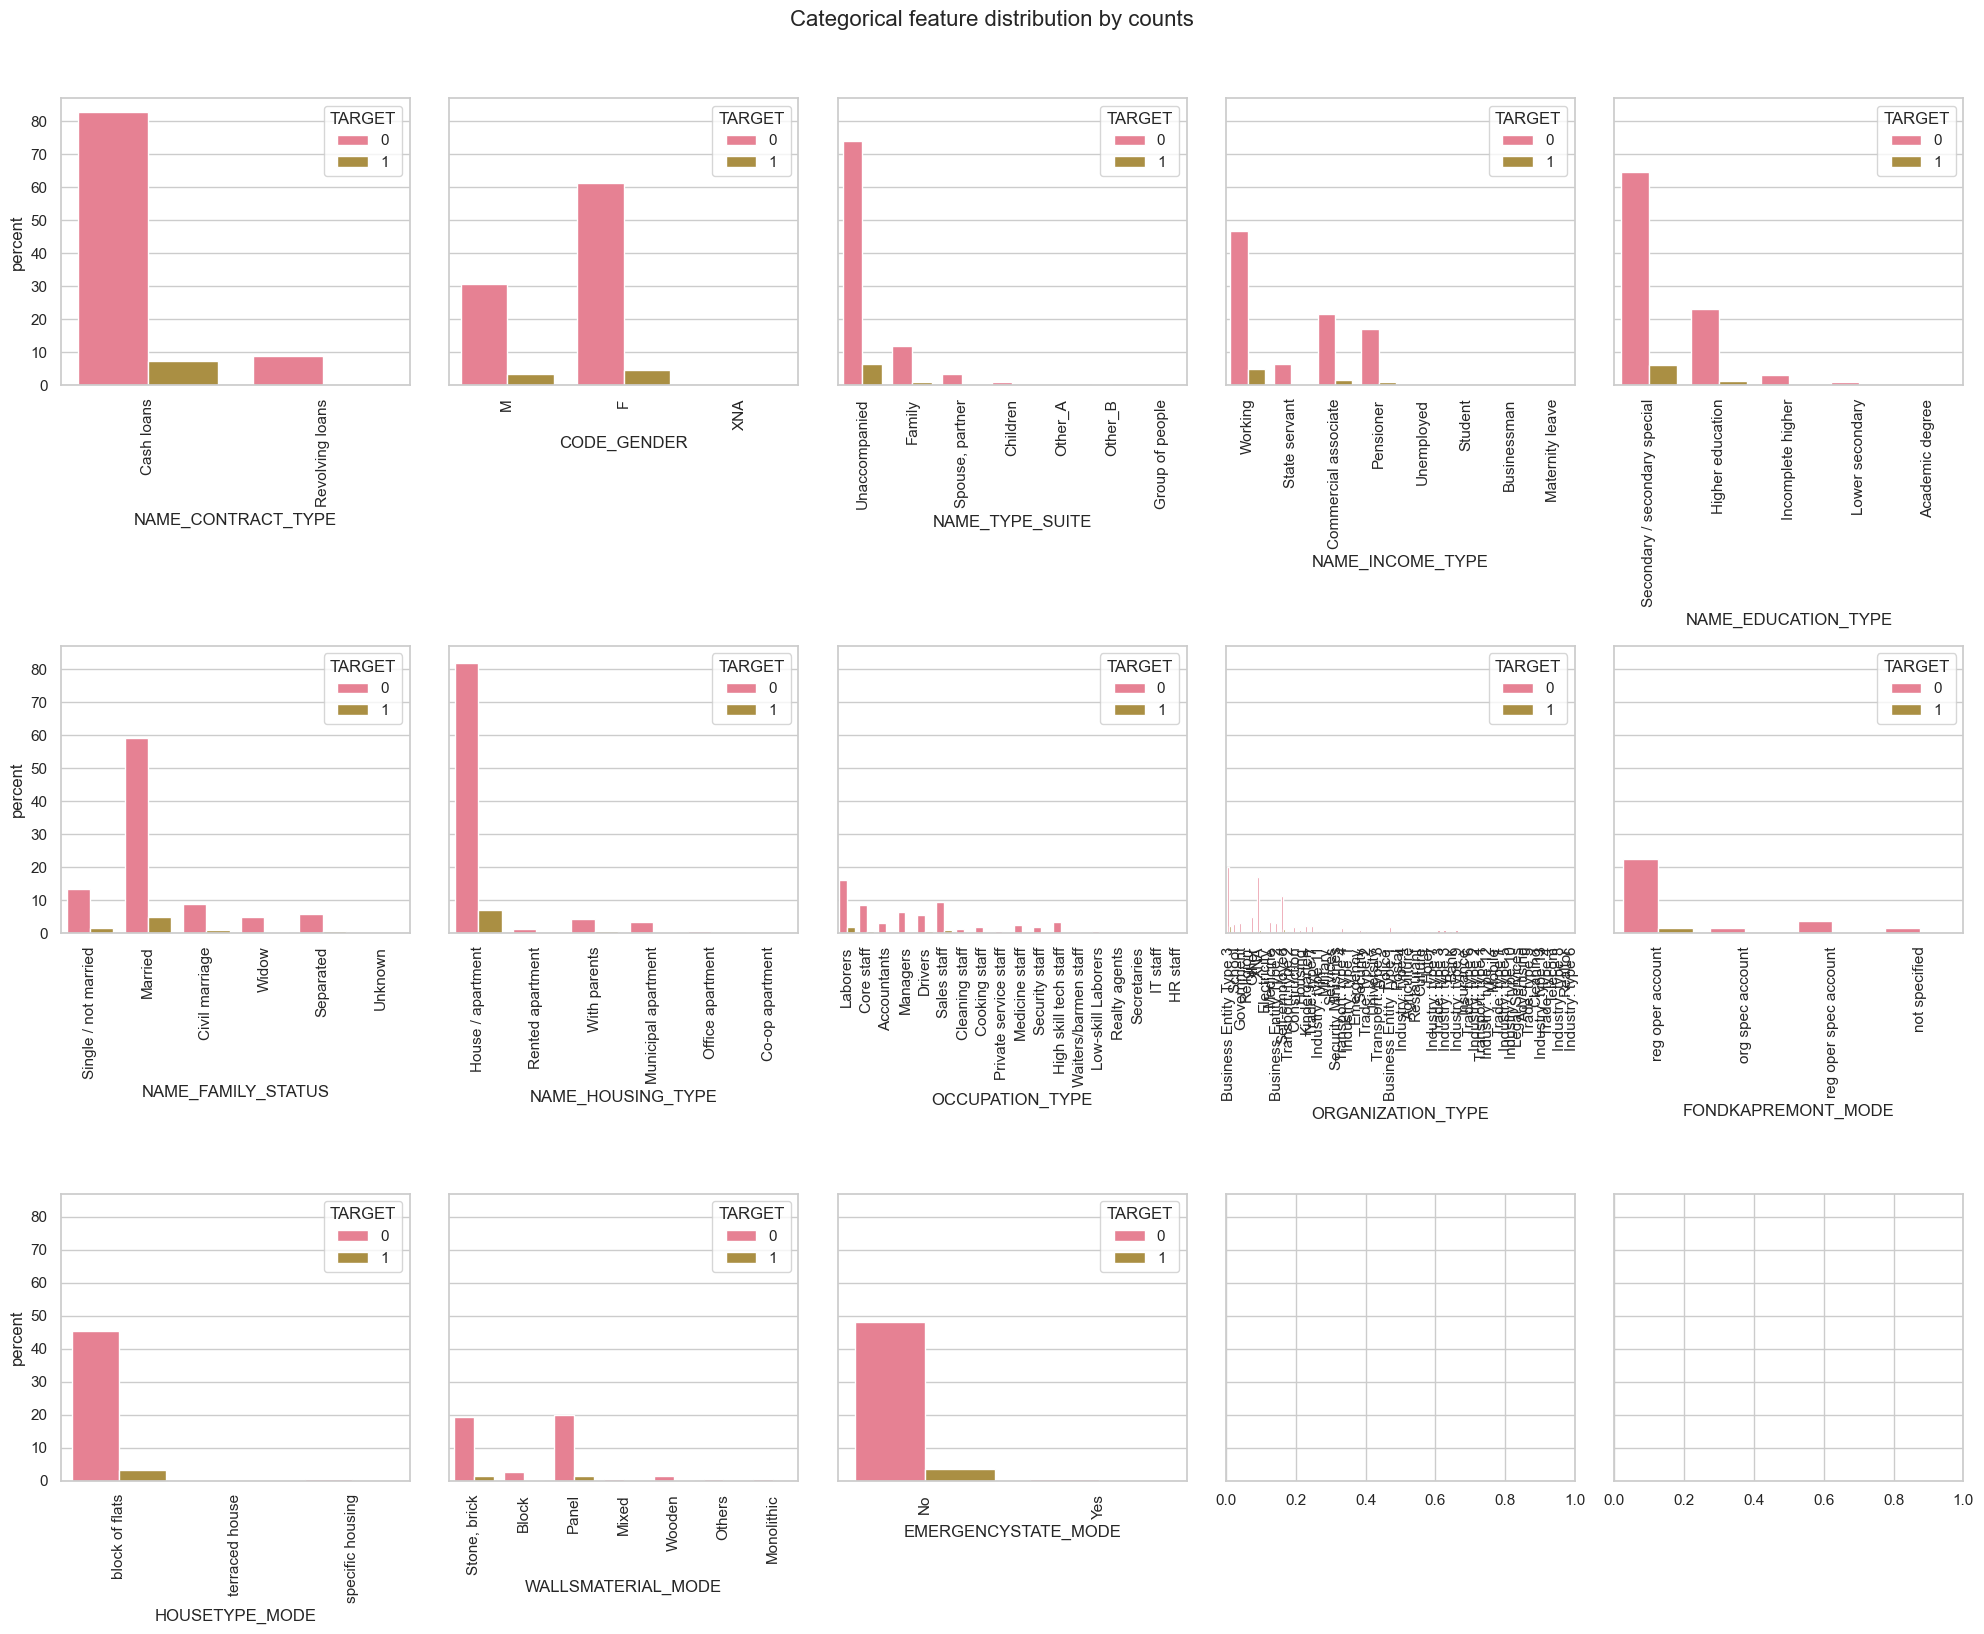

In [5]:
object_columns = application_train.select_dtypes(
    include=['object']).columns.tolist()

fig, axes = plt.subplots(3, 5, figsize=(20, 16), sharey=True)

axes = axes.flatten()

for i, col in enumerate(object_columns):
    sns.countplot(data=application_train, x=col,
                  ax=axes[i],
                  legend=True,
                  stat="percent",
                  hue='TARGET'
                  )
    axes[i].tick_params(axis='x', rotation=90)

plt.suptitle(f"Categorical feature distribution by counts", size=16, y=1.02)
plt.tight_layout()
plt.show()

From the above plots, it is seen there's no object feature with a clear dependency on Target. Thus, feature will be:
* Numerically encoded when posible (Cash Loans / not Cash Loans)
* Discrimination could be avoided by categorizing NAME_FAMILY_STATUS to single/not single.
* Education type can be numerically encoded.
* Grouped to subgroups if feature has high Cardinality (number of unique value)

In [4]:
application_train = help_tool.encode_categories(application_train)

# Feature Selection
## Variance 
A lot of features have 0 or less than 0.1 variance. One of the zero variance features is TARGET. Since the dataset is imbalanced, dropping Zero variance features could result in lost information for the minority TARGET.

In [15]:
help_model.zero_variance_features(application_train)

['TARGET',
 'REGION_POPULATION_RELATIVE',
 'FLAG_MOBIL',
 'FLAG_CONT_MOBILE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI'

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

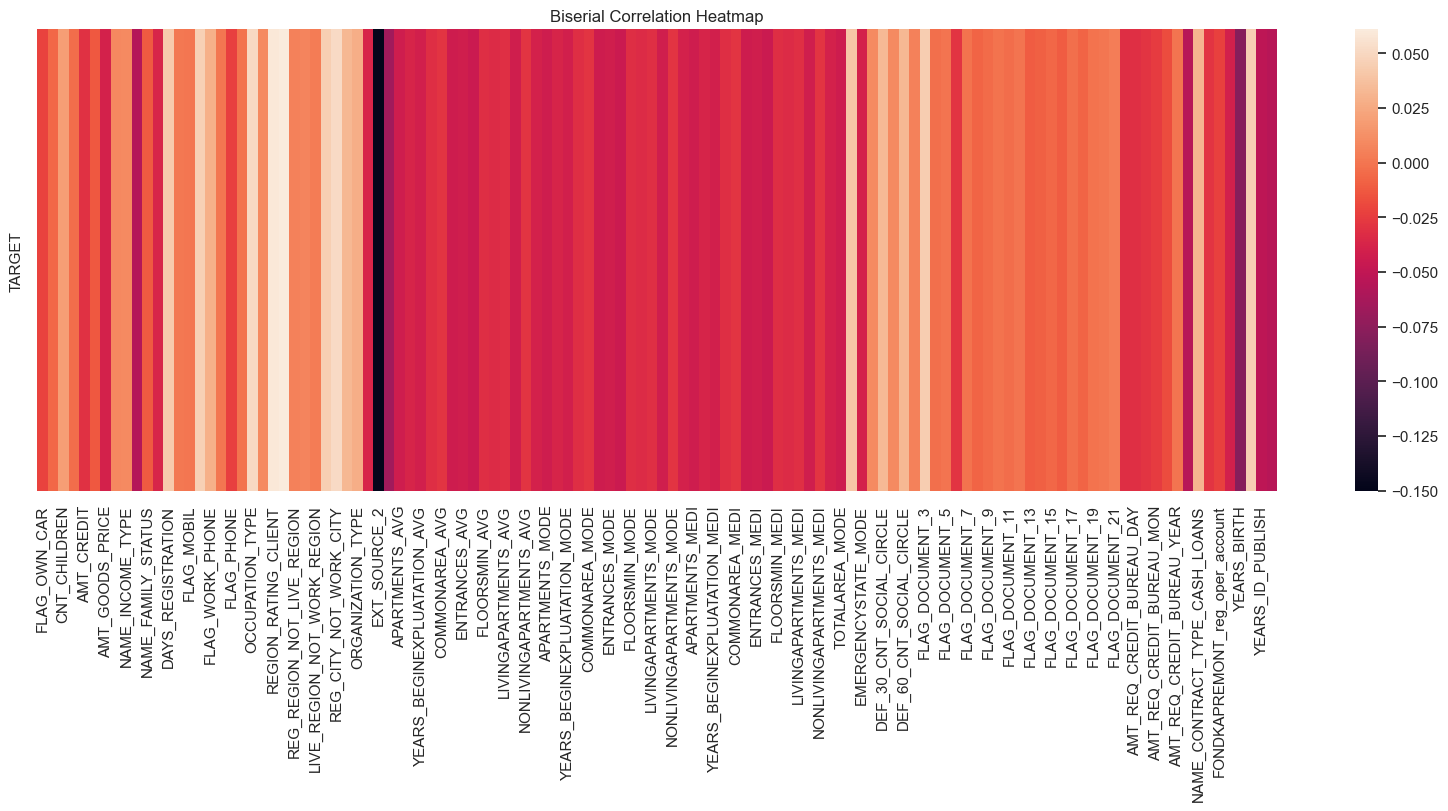

In [16]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(application_train.fillna(-1), application_train.drop(
    columns=['SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

## Adding previously created features
Taking features from Bureau and Loan monthly information, adding the aggregated groups to current application.

In [5]:
sub_data_clusters = help_tool.csv_download(
    r'Archive\home-credit-default-risk\sub_data_clusters.csv').drop(columns='Unnamed: 0')
bureau_data_clusters = help_tool.csv_download(
    r'Archive\home-credit-default-risk\sorted_bureau_feature_matrix.csv')[['SK_ID_CURR', 'Cluster_bureau']]

In [6]:
whole_data = duckdb.query("""
             SELECT 
                A.*, 
                B.*, 
                C.Cluster_bureau

             FROM application_train A
             LEFT JOIN sub_data_clusters B
             ON A.SK_ID_CURR = B.SK_ID_CURR
             LEFT JOIN bureau_data_clusters C
             ON A.SK_ID_CURR = C.SK_ID_CURR
             
             """).to_df().drop(columns='SK_ID_CURR_1')

## TRAGET
Default model Light GBM is has pretty good ROC AUC, which is not ideal, but better than random guessing. Low Precision shows model is guessing only the majority class of TARGET, neglecting the minority.

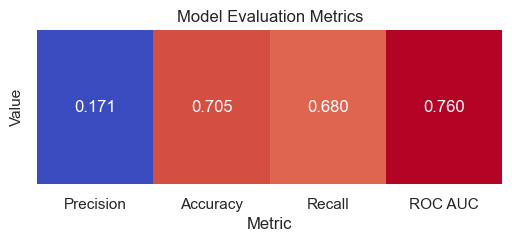

In [19]:
target_feature_importance = help_model.model_feature_importance_target(
    whole_data)

Most important feature is EXT_SOURCE_1. EDA part will be focused on imputing this value.

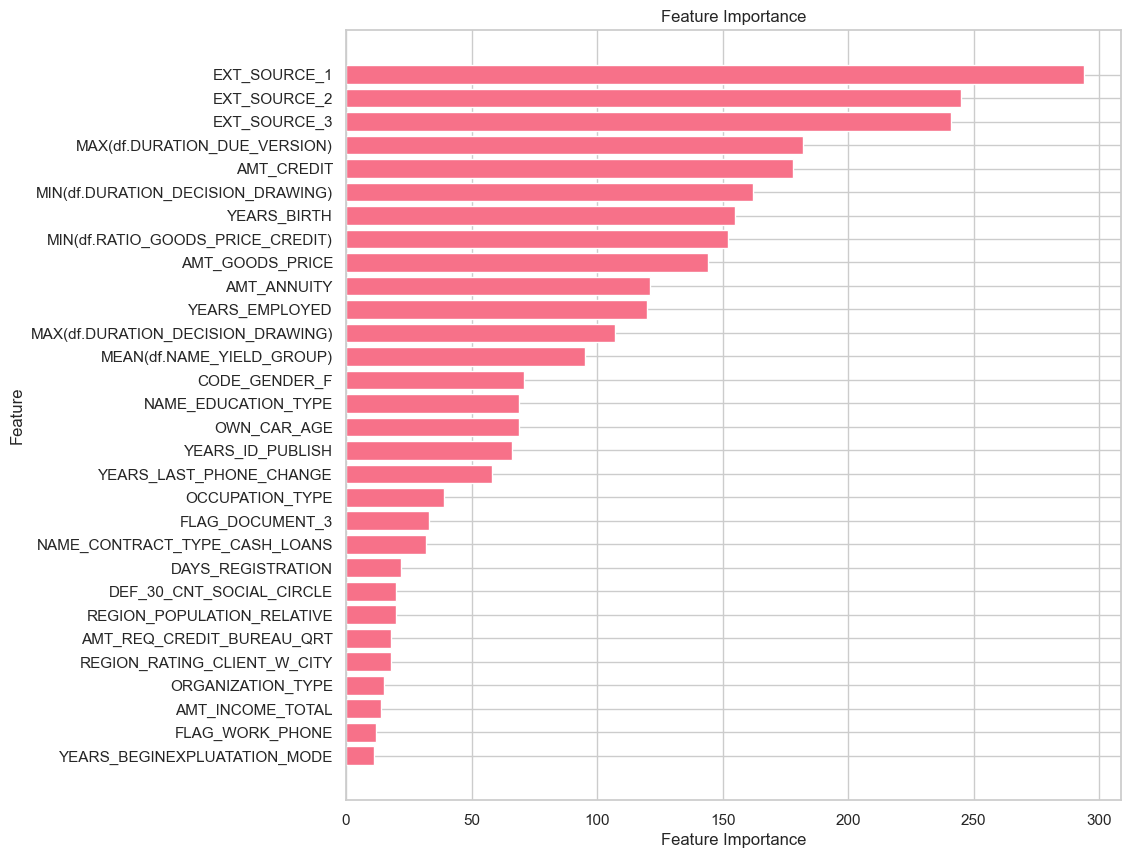

In [20]:
help_model.plot_feature_importance(target_feature_importance.head(30))

'AMT_GOODS_PRICE', 'AMT_ANNUITY' will be removed as they are heavilly correlated with AMT_CREDIT.

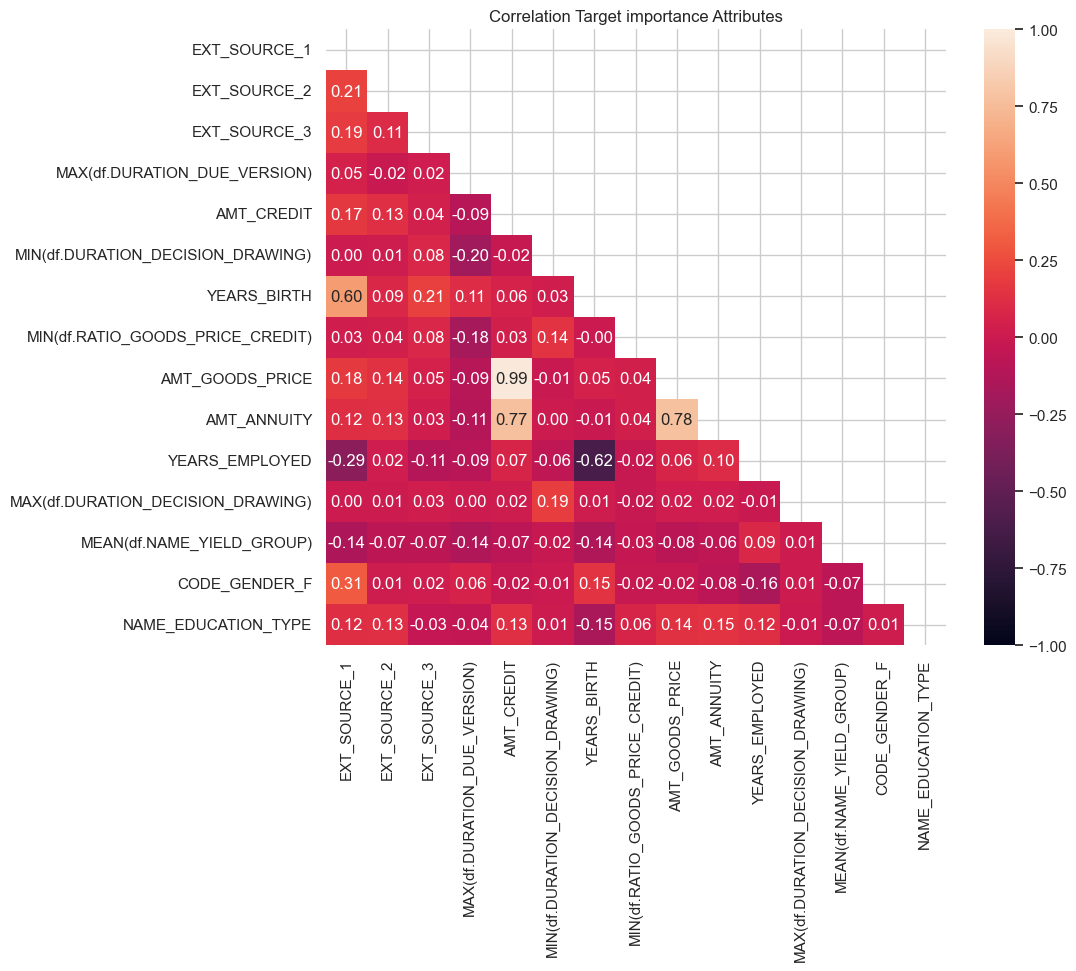

In [31]:
help_visuals.heatmap(whole_data[target_feature_importance['feature'].head(
    15).to_list()], 'TARGET importance', 'pearson')

In [28]:
target_features = whole_data[target_feature_importance['feature'].head(
    15).to_list()].drop(columns=['AMT_GOODS_PRICE', 'AMT_ANNUITY']).columns.to_list()

### Conclusion
Feature selection on TARGET has been finalized with 15 features.

## AVG_Risk_Score
'MEAN(df.NAME_YIELD_GROUP)' could be a good solution for imputation by another model, but sadly, R2 values are so low, it shows that any dependency might be random.

In [33]:
whole_data.loc[whole_data['MEAN(df.NAME_YIELD_GROUP)'] > 1, 'Not_Low_Risk'] = 1
whole_data.loc[whole_data['MEAN(df.NAME_YIELD_GROUP)'] == 1, 'Not_Low_Risk'] = 0

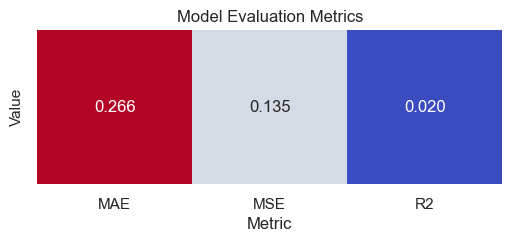

In [35]:
risk_score_features = help_model.model_feature_importance_exteranal(
    whole_data[application_train.columns.to_list() + ['Not_Low_Risk']].dropna(subset='Not_Low_Risk').sample(10000, random_state=42), 'Not_Low_Risk').head(10)

In [38]:
risk_score_features.head(5)

,feature,importance
117,YEARS_LAST_PHONE_CHANGE,225
33,EXT_SOURCE_3,174
32,EXT_SOURCE_2,164
31,EXT_SOURCE_1,130
5,AMT_ANNUITY,126


### Conclusion
YEARS_LAST_PHONE_CHANGE will be added to the list of features just in case.

## EXT_SOURCE_1
EXT_SOURCE_1 is dependent on the same set of features as TARGET, which is mainly EXT_SOURCE family. Imputing this feature could help with guessing TARGET.

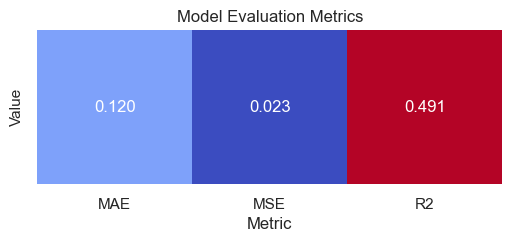

In [23]:
ext_source_1_feature_importance = help_model.model_feature_importance_exteranal(
    whole_data, 'EXT_SOURCE_1')

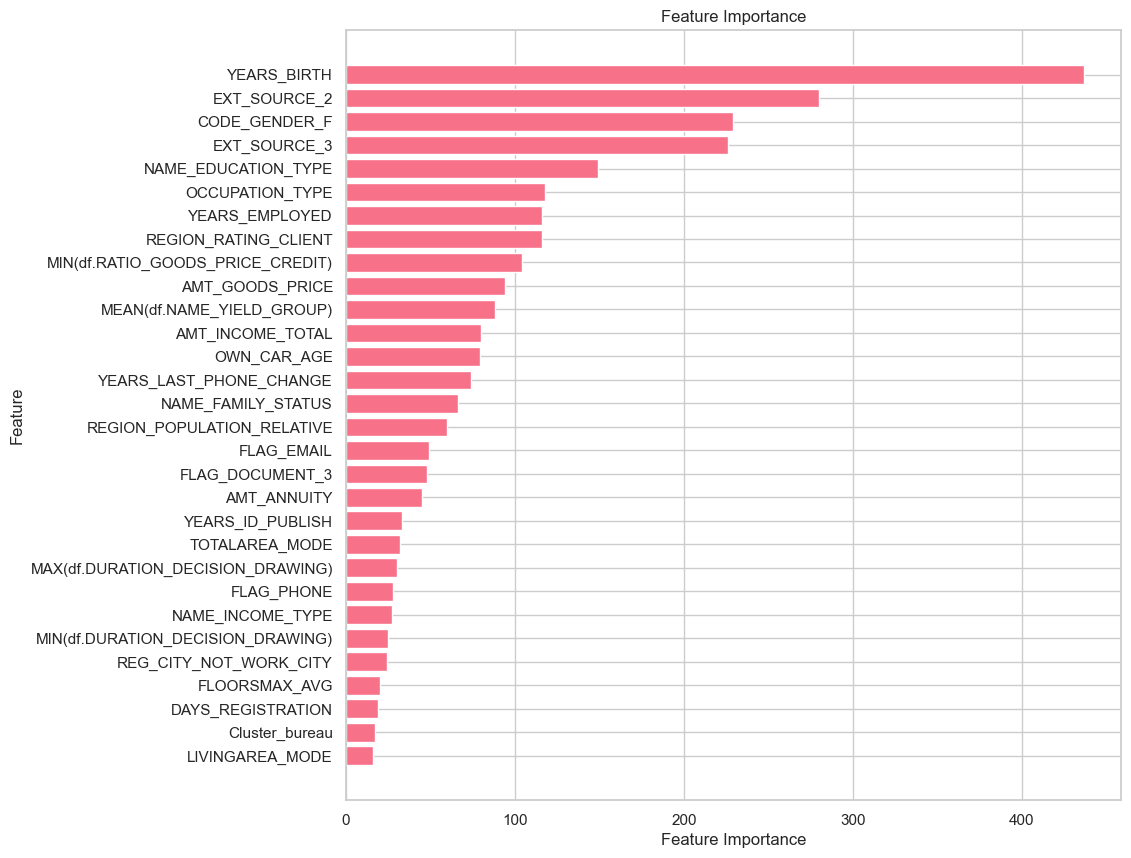

In [24]:
help_model.plot_feature_importance(ext_source_1_feature_importance.head(30))

Selected top 5 features are not correlated to each other.

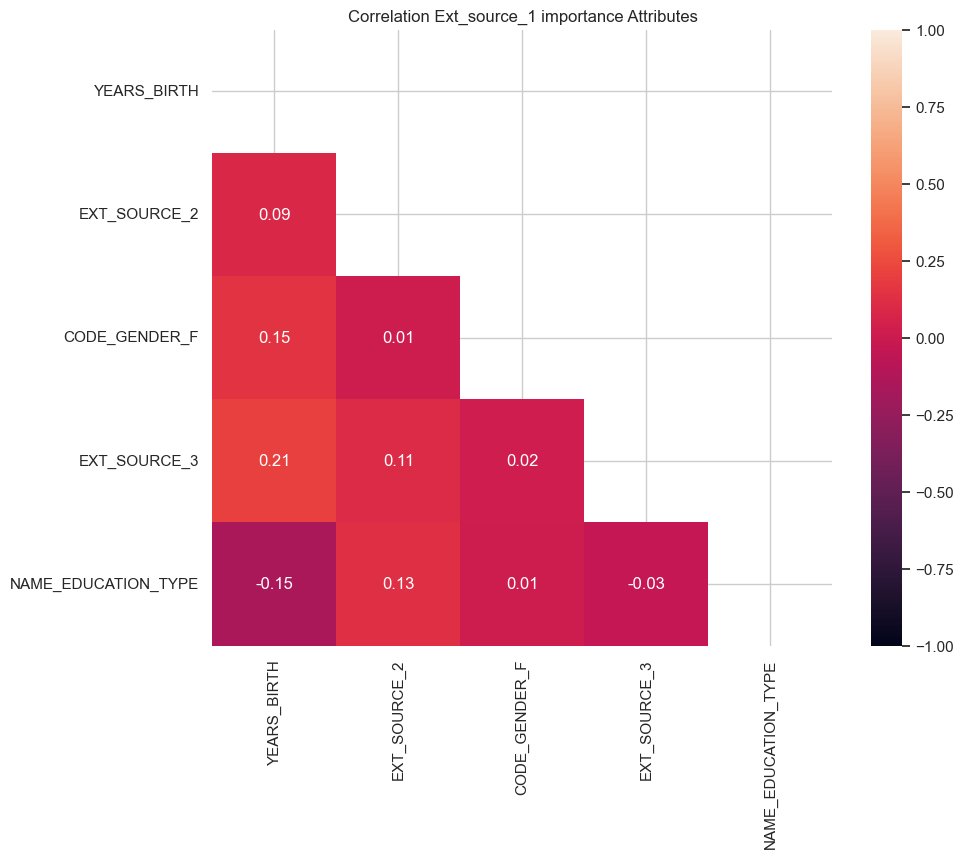

In [25]:
help_visuals.heatmap(whole_data[ext_source_1_feature_importance['feature'].head(
    5).to_list()], 'EXT_SOURCE_1 importance', 'pearson')

In [26]:
ext_source_1_features = whole_data[ext_source_1_feature_importance['feature'].head(
    5).to_list()].columns.to_list()

### Conclusion
* EXT_SOURCE has the same most important features as TARGET. No clustered features on loan repayement or bureau data have made it into the final feature list.
* Dummy model with all the available features had 0.17 in precision.

# Exporting selected list
Selected list of features for TARGET (15), EXT_SOURCE_1 and AVG_Risk_Score was created and prepared for EDA.

In [27]:
selected_features = list(
    set(target_features + ext_source_1_features)) + ['TARGET' + 'YEARS_LAST_PHONE_CHANGE']

selected_data = whole_data[selected_features].rename(
    columns={'MEAN(df.NAME_YIELD_GROUP)': 'AVG_Risk_Score'})

selected_data.to_csv(r'Archive\home-credit-default-risk\selected_data.csv')